# Split the data

In [1]:
from torch_geometric.loader import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
import torch
from collections import Counter
import sys
sys.path.append("../src")
from reachability_model_holds_features_function import ReachabilityFeaturesGNN
from torch_geometric.data import Batch
from reachability_model_holds_features_function import plot_graph_prediction, simulate_climb_to_goal
from reachability_model_holds_features_function import FocalLoss

In [2]:
# Load the Graphs with edge_attr
data = torch.load("../data/graph_list_holds_features_edgesF.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_22468\45347308.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../data/graph_list_holds_features_edgesF.pt

In [2]:
# Load the Graphs
data = torch.load("../data/graph_list_holds_features.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_16764\1844560907.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../data/graph_list_holds_features.pt")


In [3]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Option 1: Calculate the weights

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_labels = torch.cat([g.y for g in train_data])
counts = Counter(all_labels.tolist())
total = sum(counts.values())

max_cap = 5
weights = [min(np.log(total / (counts.get(i, 1) + 1)), max_cap) for i in range(4)]
weights = torch.tensor(weights, dtype=torch.float).to(device)

In [5]:
weights

tensor([0.0766, 3.2582, 3.3765, 5.0000], device='cuda:0')

# Option 2: Use Balanced to calcualte the weights

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_train_labels = []
for g in train_data:
    all_train_labels.extend(g.y.cpu().numpy())  

classes = np.unique(all_train_labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=all_train_labels)

weights = np.clip(weights, a_min=None, a_max=5.0)
weights = torch.tensor(weights, dtype=torch.float).to(device)

In [5]:
weights

tensor([0.2699, 5.0000, 5.0000, 5.0000], device='cuda:0')

# Option 3: Manual boost for rare class

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_labels = torch.cat([g.y for g in train_data]).cpu().numpy()

classes = np.unique(all_labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=all_labels)
weights = np.clip(weights, a_min=None, a_max=5.0)

# Boost the type 3
boost_factor = 2.5
weights[3] *= boost_factor

weights = torch.tensor(weights, dtype=torch.float).to(device)

In [8]:
weights

tensor([ 0.2699,  5.0000,  5.0000, 12.5000], device='cuda:0')

# Train the Model

In [9]:
loader = DataLoader(train_data, batch_size=8, shuffle=True)
model = ReachabilityFeaturesGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# CrossEntropyLoss
# loss_fn = CrossEntropyLoss(weight=weights)

# FocalLoss
loss_fn = FocalLoss(gamma=1.0, weight=weights)

for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        loss = loss_fn(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 350.3362
Epoch 2: Loss = 132.0508
Epoch 3: Loss = 108.7657
Epoch 4: Loss = 94.7283
Epoch 5: Loss = 88.3629
Epoch 6: Loss = 85.3990
Epoch 7: Loss = 77.0885
Epoch 8: Loss = 77.5430
Epoch 9: Loss = 72.3276
Epoch 10: Loss = 71.8374
Epoch 11: Loss = 69.8762
Epoch 12: Loss = 72.4127
Epoch 13: Loss = 72.0029
Epoch 14: Loss = 74.3310
Epoch 15: Loss = 69.1990
Epoch 16: Loss = 67.0576
Epoch 17: Loss = 67.6367
Epoch 18: Loss = 91.0101
Epoch 19: Loss = 68.3728
Epoch 20: Loss = 67.1157
Epoch 21: Loss = 65.9934
Epoch 22: Loss = 65.0695
Epoch 23: Loss = 61.6138
Epoch 24: Loss = 63.0325
Epoch 25: Loss = 81.1252
Epoch 26: Loss = 66.5064
Epoch 27: Loss = 62.4342
Epoch 28: Loss = 64.0400
Epoch 29: Loss = 63.2149
Epoch 30: Loss = 65.4358
Epoch 31: Loss = 64.5273
Epoch 32: Loss = 61.7350
Epoch 33: Loss = 61.7293
Epoch 34: Loss = 59.8940
Epoch 35: Loss = 57.7588
Epoch 36: Loss = 56.8110
Epoch 37: Loss = 55.3814
Epoch 38: Loss = 55.1359
Epoch 39: Loss = 55.8179
Epoch 40: Loss = 56.3477
Epoch 

In [30]:
model.eval()
all_preds = []

with torch.no_grad():
    for g in train_data:
        batch = Batch.from_data_list([g]).to(device) 
        out = model(batch)                    
        pred = out.argmax(dim=1)
        all_preds.extend(pred.tolist())

print("Distribution of Predictions:", Counter(all_preds))

Distribution of Predictions: Counter({0: 1217000, 1: 56362, 2: 48563, 3: 2154})


In [12]:
torch.save(model.state_dict(),"reachability_features_model12.pt")

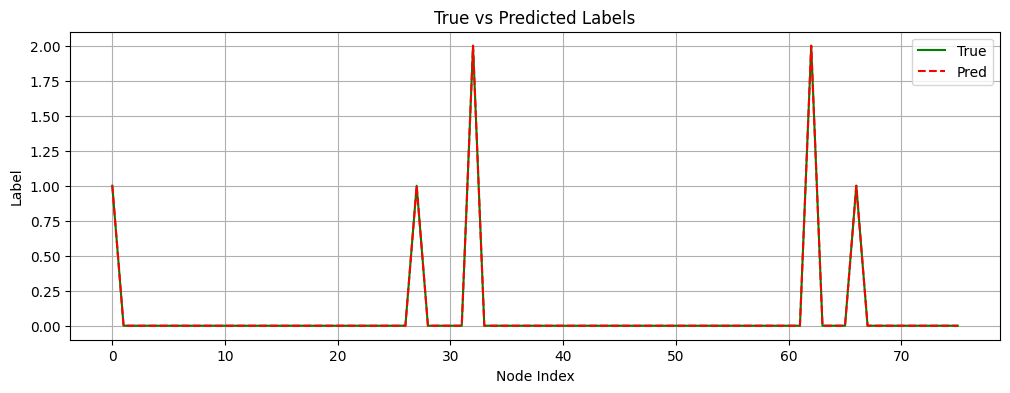

In [10]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
graph = test_data[1200]
batch = Batch.from_data_list([graph])
batch = batch.to(device)

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import classification_report

all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

              precision    recall  f1-score   support

 unreachable       1.00      0.99      1.00    302683
        hand       0.90      1.00      0.95     12683
        foot       0.93      1.00      0.96     11289
        both       0.56      0.85      0.67       363

    accuracy                           0.99    327018
   macro avg       0.85      0.96      0.90    327018
weighted avg       0.99      0.99      0.99    327018



# Load already had model to check the performance

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReachabilityFeaturesGNN().to(device)
model.load_state_dict(torch.load("reachability_features_model8.pt"))
model.eval()

C:\Users\guanj\AppData\Local\Temp\ipykernel_21472\2375973721.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("reachability_features_mode

ReachabilityFeaturesGNN(
  (conv1): GATv2Conv(10, 64, heads=4)
  (norm1): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATv2Conv(256, 64, heads=1)
  (norm2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (climber_embed): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [2]:
graph_list = torch.load("../data/graph_list_holds_features_edgesF.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_7944\81071896.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("../data/graph_list_holds_features_edge

In [4]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)

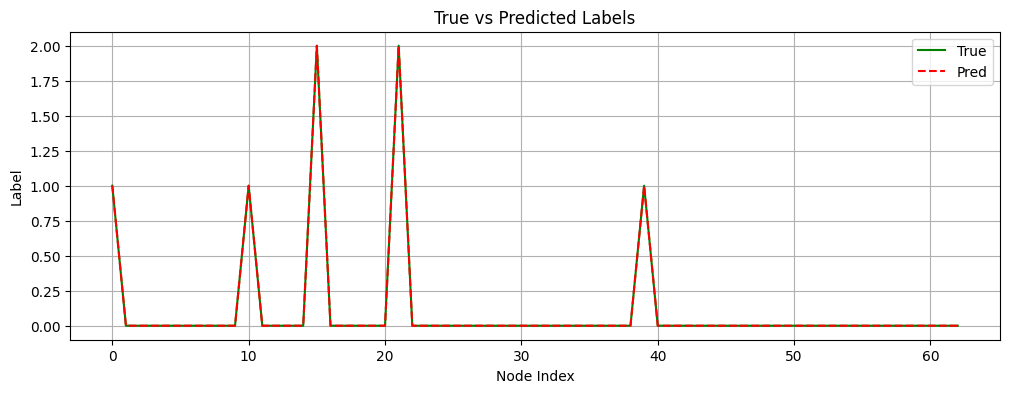

In [5]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
graph = test_data[2450]
batch = Batch.from_data_list([graph])
batch = batch.to(device)

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import classification_report

all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

              precision    recall  f1-score   support

 unreachable       1.00      0.99      0.99    302683
        hand       0.87      0.99      0.93     12683
        foot       0.86      1.00      0.93     11289
        both       0.66      1.00      0.80       363

    accuracy                           0.99    327018
   macro avg       0.85      1.00      0.91    327018
weighted avg       0.99      0.99      0.99    327018



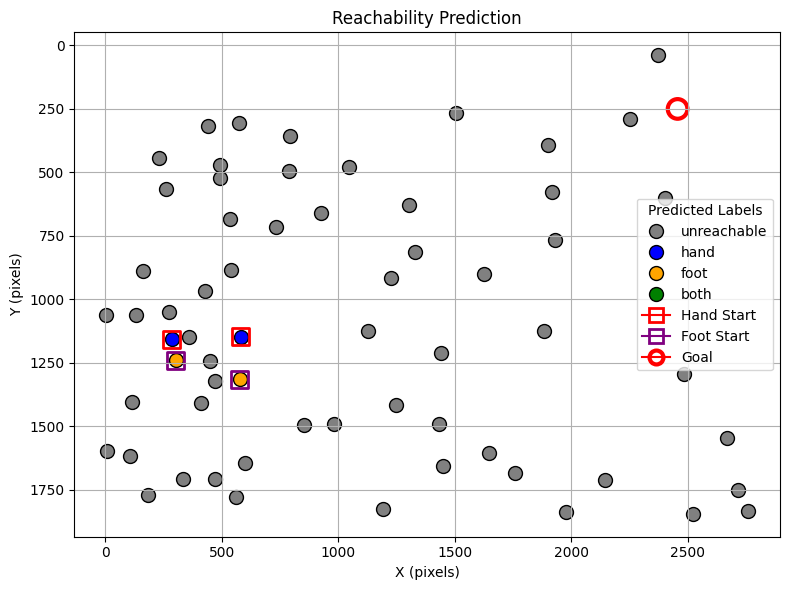

In [6]:
graph = test_data[5320]
import copy
g = copy.deepcopy(graph)
g.climber = torch.tensor([[170.4000,   1.0500,   8.0000,   0.5093,  60.9000,  80.0000]])
batch = Batch.from_data_list([g])
plot_graph_prediction(batch, model, "Reachability Prediction", (2456, 250))

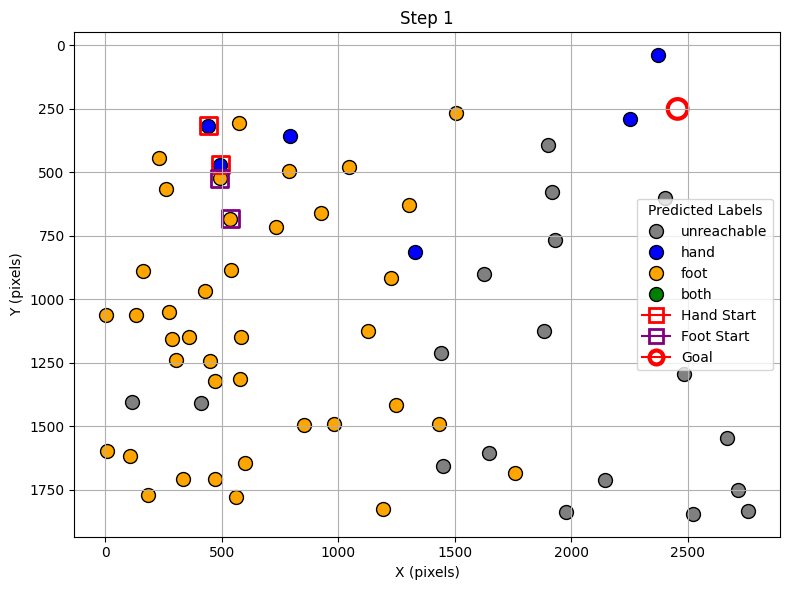

Success: Model predict climber can reach the goal (label=1) in Step 1


In [31]:
simulate_climb_to_goal(batch, model, (2456, 250))